# TO DO'S

 - Data augmentation
     - shift
     - mirror?? (maybe not)
     - PCA? (why not)
 - reduce overfitting
 - if outliers use robust_scale of skipy
 - check http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [1]:
import torch
import math

from torch import Tensor
from torch import optim
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn
# for plots
from matplotlib import pyplot as plt
# for progress bar
from tqdm import tqdm, trange
# from the same folder:
import dlc_bci as bci
from models import *
import helpers
import antoine_models as ant
import luca_models as lm
# easier matrix manipulations
import numpy as np

SEED = 50

# IPython magics
%load_ext autoreload
%autoreload 2

# Parameters

In [93]:
# PARAMETERS
CRIT = 'cross' # 'MSE'
HD_SIGNAL = True
SIGNAL_LENGTH = 500 # correspond to HD_SIGNAL = True usually

noise_DA = False
subsampling_DA = False
if subsampling_DA == True:
    SIGNAL_LENGTH = 50

n_splits_K_fold = 2

### Get data

In [94]:
# load data as numpy
train_input, test_input, train_target, test_target = helpers.get_data_as_numpy(HD_SIGNAL, CRIT)
# normalise the data
train_input = helpers.normalize_data(train_input)
test_input = helpers.normalize_data(test_input)

### Data augmentation
# Do we want noised data augmentation?
if noise_DA == True:
    train_input, train_target = helpers.noise_DA(my_input, my_target, std=1/2)

# subsamplig data augmentation?
if subsampling_DA == True:
    train_input, train_target = helpers.from_numpy_to_torch(train_input, train_target, CRIT)
    test_input, test_target = helpers.from_numpy_to_torch(test_input, test_target, CRIT)
    
    train_input, train_target = helpers.subsampling_DA(train_input, train_target)
    test_input, test_target = helpers.subsampling_DA(test_input, test_target)
    
    train_input, train_target = train_input.data.numpy(), train_target.data.numpy()
    test_input, test_target = test_input.data.numpy(), test_target.data.numpy()

# K-fold cross validation
if n_splits_K_fold>1:
    train_indices, test_indices = helpers.cross_validation(train_input, train_target,n_splits_K_fold)

# convert numpy to Variables
train_input, train_target = helpers.from_numpy_to_torch(train_input, train_target, CRIT)
test_input, test_target = helpers.from_numpy_to_torch(test_input, test_target, CRIT)

# final check

helpers.final_check(train_input,train_target,test_input,test_target)

<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])
train --- mean 24.05, std: 41.53 target mean:  0.49683544303797467
test --- mean 21.69, std: 40.85 target mean:  0.51
KFold with K= 2
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train_input:  <class 'torch.autograd.variable.Variable'> torch.Size([316, 28, 500])
train_target:  <class 'torch.autograd.variable.Variable'> torch.Size([316])

----------------------------------------------------------------
train --- mean 0.00000, std: 1.00 target mean:  0.49683544303797467
test --- mean -0.00000, std: 1.00 target mean:  0.51


### Baseline:

In [131]:
# not with subsampling_DA

helpers.lousy_baselines(train_input = train_input, train_target=train_target,\
                         test_input = test_input, test_target = test_target,\
                         with_pca = False, nb_channels_pca = 10)

--------------  SVM BASELINE -----------------
47.0 %
--------------  KNN BASELINE -----------------
44.0 %


### Helper Functions:

In [96]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size, signal_length,Conv2D=False):
    
    if Conv2D == True:
        data_input = Variable(torch.unsqueeze(data_input.data,1))
    nb_errors = 0
    for i in range(0, data_input.size(0)):
        model.train(False)
        if model.training == False:
            if Conv2D == True:
                output = model.forward(data_input[i].view(1,1,28,signal_length))
            else:
                output = model.forward(data_input[i].view(1,28,signal_length))
        else : print('DROPING OUT IN TESTING')
        _, predicted = torch.max(output.data, 1)                            
        true_val = data_target.data[i]
        if CRIT == 'MSE':
            true_val = true_val[0]
        predicted = predicted[0]
        if (true_val != predicted[0]):
            nb_errors += 1
    return nb_errors

In [99]:
def train_model(model, train_input, train_target,test_input, test_target, mini_batch_size,\
                verbose=False, Conv2D = False):  
    # initialise weight
    #weights_init(model)
    #model.apply(weights_init)
    
    #optimizer = torch.optim.SGD(model.parameters(), lr = eta)
    optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=0.001)
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.4)
    
    if Conv2D == True:
        print('converted for conv2d')
        train_input = Variable(torch.unsqueeze(train_input.data,1))
        #train_target = Variable(torch.unsqueeze(train_target.data,1),requires_grad=True)
    
    train_list = []
    test_list  = []
    for e in trange(epochs):
    #for e in range(epochs):       
        train_input, train_target = helpers.shuffle_data(input_=train_input, target_=train_target)
        for b in range(0, train_input.size(0), mini_batch_size):
            model.train(True)
            if model.training == True:
                output = model.forward(train_input[b:b+mini_batch_size])
            else : print('NOT TRAINING')
            #print('output size: ', output.size()) 
            #print('target size: ', train_target[b:b+mini_batch_size].size())
            #print( output)
            #print(train_target[b:b+mini_batch_size])
            loss = criterion(output, train_target[b:b+mini_batch_size])
            model.zero_grad()
            loss.backward()
            optimizer.step()

        if (e%10==0):
            train_errors = compute_nb_errors(model, data_input=train_input, data_target=train_target,\
                                             mini_batch_size= mini_batch_size,signal_length=SIGNAL_LENGTH,\
                                            Conv2D=Conv2D)
            test_errors = compute_nb_errors(model, data_input=test_input, data_target=test_target,\
                                           mini_batch_size = mini_batch_size,signal_length=SIGNAL_LENGTH,\
                                           Conv2D=Conv2D)
            train_list.append(train_errors)
            test_list.append(test_errors)
            if verbose == True:
                print('epoch #',e,\
                      'Train: {:0.2f}%'.format( train_errors/train_input.size(0)*100),\
                      'Val:  {:0.2f}%'.format(test_errors / test_input.size(0)*100),\
                      )
            #print('Loss:  {:0.5f} '.format(loss.data[0]))
    return train_list, test_list

            

### Parameters: 

In [160]:
mini_batch_size = 15
epochs = 400

eta = 0.001

if CRIT == 'MSE':
    criterion = nn.MSELoss()
elif CRIT == 'cross':
    criterion = nn.CrossEntropyLoss()



# Testing Zone:

In [161]:
#model_list = [create_model_1, create_net_seq]
# for m in model_list:

def create_net_seq(num = 2, nl='relu'):
    if num == 0:
        return lm.Net_seq(nl=nl)
    elif num == 1:
        if dil_10 == True:
            return lm.DilatedNet(nl=nl,length_signal = 500)
        else :
            return lm.DilatedNet(nl=nl)
    elif num == 2:
        return lm.DilatedNet2(nl=nl,length_signal = 500)
    elif num == 3:
        return lm.DilatedNet3(nl=nl,length_signal = 500)
    elif num == 4:
        return lm.DilatedNet4(nl=nl,length_signal = 500)
    elif num==10:
        return ant.MyNet(True)
    elif num == 11:
        return ant.MyNetDA(True)
    
ant_2d_models = [10,11]
    

m = create_net_seq
print(m.__name__)



########################3 model  ###############
num_model = 2


Conv2D = False
if num_model in ant_2d_models:     
    Conv2D = True           

create_net_seq


In [162]:
print(Conv2D)

False


In [163]:
train_list_list = []
val_list_list   = []
train_size_list = []
val_size_list   = []
if n_splits_K_fold>1:
    for train_index, test_index in [train_indices, test_indices]:
        ###################### import model #####################
        model = m(num_model)
        #########################################################
        X_train, X_test = train_input.data.numpy()[train_index], train_input.data.numpy()[test_index]
        y_train, y_test = train_target.data.numpy()[train_index], train_target.data.numpy()[test_index]
        # reconvert them to variables
        X_train, y_train = helpers.from_numpy_to_torch(X_train, y_train, CRIT)
        X_test, y_test = helpers.from_numpy_to_torch(X_test, y_test, CRIT)

        train_list, val_list = train_model(model, train_input=X_train, train_target=y_train,\
                                            test_input = X_test, test_target = y_test,\
                                            mini_batch_size=mini_batch_size,verbose=True, Conv2D = Conv2D)

        print(len(train_list),len(val_list))
        train_list_list.append(train_list)
        val_list_list.append(val_list)
        train_size_list.append(X_train.size(0))
        val_size_list.append(X_test.size(0))


  0%|          | 1/400 [00:01<11:09,  1.68s/it]

epoch # 0 Train: 50.00% Val:  49.37%



  2%|▏         | 9/400 [00:08<06:27,  1.01it/s]
Exception in thread Thread-73:
Traceback (most recent call last):
  File "/home/zampieri/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/zampieri/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  3%|▎         | 11/400 [00:11<06:39,  1.03s/it]

epoch # 10 Train: 18.35% Val:  43.67%


  5%|▌         | 21/400 [00:21<06:22,  1.01s/it]

epoch # 20 Train: 10.13% Val:  43.67%


  8%|▊         | 31/400 [00:30<06:06,  1.01it/s]

epoch # 30 Train: 3.16% Val:  42.41%


 10%|█         | 41/400 [00:39<05:44,  1.04it/s]

epoch # 40 Train: 2.53% Val:  37.97%


 13%|█▎        | 51/400 [00:55<06:16,  1.08s/it]

epoch # 50 Train: 4.43% Val:  36.08%


 15%|█▌        | 61/400 [01:04<05:55,  1.05s/it]

epoch # 60 Train: 0.00% Val:  37.97%


 18%|█▊        | 71/400 [01:13<05:38,  1.03s/it]

epoch # 70 Train: 0.00% Val:  37.97%


 20%|██        | 81/400 [01:21<05:21,  1.01s/it]

epoch # 80 Train: 1.90% Val:  37.97%


 23%|██▎       | 91/400 [01:31<05:09,  1.00s/it]

epoch # 90 Train: 1.90% Val:  37.34%


 25%|██▌       | 101/400 [01:39<04:53,  1.02it/s]

epoch # 100 Train: 0.00% Val:  34.81%


 28%|██▊       | 111/400 [01:48<04:42,  1.02it/s]

epoch # 110 Train: 3.16% Val:  36.08%


 30%|███       | 121/400 [01:57<04:30,  1.03it/s]

epoch # 120 Train: 1.27% Val:  32.28%


 33%|███▎      | 131/400 [02:06<04:20,  1.03it/s]

epoch # 130 Train: 0.00% Val:  34.18%


 35%|███▌      | 141/400 [02:14<04:07,  1.05it/s]

epoch # 140 Train: 0.63% Val:  34.18%


 38%|███▊      | 151/400 [02:22<03:55,  1.06it/s]

epoch # 150 Train: 0.63% Val:  36.08%


 40%|████      | 161/400 [02:30<03:43,  1.07it/s]

epoch # 160 Train: 0.00% Val:  32.28%


 43%|████▎     | 171/400 [02:38<03:32,  1.08it/s]

epoch # 170 Train: 1.27% Val:  31.65%


 45%|████▌     | 181/400 [02:47<03:22,  1.08it/s]

epoch # 180 Train: 0.00% Val:  37.97%


 48%|████▊     | 191/400 [02:56<03:12,  1.08it/s]

epoch # 190 Train: 0.00% Val:  34.81%


 50%|█████     | 201/400 [03:06<03:04,  1.08it/s]

epoch # 200 Train: 0.00% Val:  31.01%


 53%|█████▎    | 211/400 [03:15<02:54,  1.08it/s]

epoch # 210 Train: 0.00% Val:  31.65%


 55%|█████▌    | 221/400 [03:24<02:45,  1.08it/s]

epoch # 220 Train: 0.00% Val:  34.18%


 58%|█████▊    | 231/400 [03:33<02:35,  1.08it/s]

epoch # 230 Train: 0.00% Val:  31.65%


 60%|██████    | 241/400 [03:41<02:26,  1.09it/s]

epoch # 240 Train: 0.00% Val:  29.75%


 63%|██████▎   | 251/400 [03:50<02:16,  1.09it/s]

epoch # 250 Train: 0.00% Val:  31.01%


 65%|██████▌   | 261/400 [04:00<02:07,  1.09it/s]

epoch # 260 Train: 0.63% Val:  30.38%


 68%|██████▊   | 271/400 [04:09<01:58,  1.09it/s]

epoch # 270 Train: 0.00% Val:  30.38%


 70%|███████   | 281/400 [04:18<01:49,  1.09it/s]

epoch # 280 Train: 0.00% Val:  31.65%


 73%|███████▎  | 291/400 [04:27<01:40,  1.09it/s]

epoch # 290 Train: 0.00% Val:  32.91%


 75%|███████▌  | 301/400 [04:36<01:30,  1.09it/s]

epoch # 300 Train: 0.00% Val:  27.22%


 78%|███████▊  | 311/400 [04:45<01:21,  1.09it/s]

epoch # 310 Train: 0.63% Val:  27.85%


 80%|████████  | 321/400 [04:53<01:12,  1.09it/s]

epoch # 320 Train: 0.63% Val:  33.54%


 83%|████████▎ | 331/400 [05:02<01:02,  1.10it/s]

epoch # 330 Train: 0.00% Val:  28.48%


 85%|████████▌ | 341/400 [05:11<00:53,  1.09it/s]

epoch # 340 Train: 0.00% Val:  27.22%


 88%|████████▊ | 351/400 [05:20<00:44,  1.10it/s]

epoch # 350 Train: 0.00% Val:  27.85%


 90%|█████████ | 361/400 [05:29<00:35,  1.09it/s]

epoch # 360 Train: 0.00% Val:  34.18%


 93%|█████████▎| 371/400 [05:38<00:26,  1.10it/s]

epoch # 370 Train: 0.00% Val:  25.32%


 95%|█████████▌| 381/400 [05:46<00:17,  1.10it/s]

epoch # 380 Train: 1.27% Val:  30.38%


 98%|█████████▊| 391/400 [05:55<00:08,  1.10it/s]

epoch # 390 Train: 0.00% Val:  28.48%


  0%|          | 0/400 [00:00<?, ?it/s]

40 40


  0%|          | 1/400 [00:01<08:50,  1.33s/it]

epoch # 0 Train: 48.10% Val:  52.53%


  3%|▎         | 11/400 [00:09<05:25,  1.19it/s]

epoch # 10 Train: 17.09% Val:  47.47%


  5%|▌         | 21/400 [00:17<05:15,  1.20it/s]

epoch # 20 Train: 12.03% Val:  39.87%


  8%|▊         | 31/400 [00:24<04:56,  1.25it/s]

epoch # 30 Train: 4.43% Val:  33.54%


 10%|█         | 41/400 [00:32<04:42,  1.27it/s]

epoch # 40 Train: 10.76% Val:  33.54%


 13%|█▎        | 51/400 [00:39<04:32,  1.28it/s]

epoch # 50 Train: 1.90% Val:  32.91%


 15%|█▌        | 61/400 [00:48<04:30,  1.25it/s]

epoch # 60 Train: 8.86% Val:  36.71%


 18%|█▊        | 71/400 [01:03<04:54,  1.12it/s]

epoch # 70 Train: 1.90% Val:  34.18%


 20%|██        | 81/400 [01:18<05:10,  1.03it/s]

epoch # 80 Train: 0.00% Val:  28.48%


 23%|██▎       | 91/400 [01:32<05:12,  1.01s/it]

epoch # 90 Train: 0.00% Val:  29.11%


 25%|██▌       | 101/400 [01:42<05:04,  1.02s/it]

epoch # 100 Train: 0.00% Val:  25.32%


 28%|██▊       | 111/400 [01:52<04:53,  1.02s/it]

epoch # 110 Train: 0.00% Val:  27.85%


 30%|███       | 121/400 [02:02<04:43,  1.02s/it]

epoch # 120 Train: 0.63% Val:  25.32%


 33%|███▎      | 131/400 [02:13<04:34,  1.02s/it]

epoch # 130 Train: 1.27% Val:  24.68%


 35%|███▌      | 141/400 [02:24<04:26,  1.03s/it]

epoch # 140 Train: 1.27% Val:  29.75%


 38%|███▊      | 151/400 [02:33<04:13,  1.02s/it]

epoch # 150 Train: 5.70% Val:  25.32%


 40%|████      | 161/400 [02:43<04:02,  1.01s/it]

epoch # 160 Train: 0.00% Val:  24.68%


 43%|████▎     | 171/400 [02:51<03:49,  1.00s/it]

epoch # 170 Train: 0.00% Val:  25.32%


 45%|████▌     | 181/400 [03:01<03:39,  1.00s/it]

epoch # 180 Train: 0.00% Val:  24.68%


 48%|████▊     | 191/400 [03:10<03:27,  1.01it/s]

epoch # 190 Train: 1.90% Val:  30.38%


 50%|█████     | 201/400 [03:19<03:17,  1.01it/s]

epoch # 200 Train: 0.63% Val:  26.58%


 53%|█████▎    | 211/400 [03:27<03:05,  1.02it/s]

epoch # 210 Train: 0.00% Val:  25.95%


 55%|█████▌    | 221/400 [03:36<02:55,  1.02it/s]

epoch # 220 Train: 0.00% Val:  27.85%


 58%|█████▊    | 231/400 [03:44<02:44,  1.03it/s]

epoch # 230 Train: 0.00% Val:  25.95%


 60%|██████    | 241/400 [03:53<02:34,  1.03it/s]

epoch # 240 Train: 0.00% Val:  24.68%


 63%|██████▎   | 251/400 [04:02<02:23,  1.04it/s]

epoch # 250 Train: 0.00% Val:  24.68%


 65%|██████▌   | 261/400 [04:10<02:13,  1.04it/s]

epoch # 260 Train: 0.00% Val:  24.68%


 68%|██████▊   | 271/400 [04:18<02:03,  1.05it/s]

epoch # 270 Train: 0.00% Val:  23.42%


 70%|███████   | 281/400 [04:26<01:52,  1.05it/s]

epoch # 280 Train: 0.00% Val:  27.85%


 73%|███████▎  | 291/400 [04:35<01:43,  1.06it/s]

epoch # 290 Train: 0.00% Val:  25.95%


 75%|███████▌  | 301/400 [04:43<01:33,  1.06it/s]

epoch # 300 Train: 0.00% Val:  25.32%


 78%|███████▊  | 311/400 [04:51<01:23,  1.07it/s]

epoch # 310 Train: 0.00% Val:  27.85%


 80%|████████  | 321/400 [04:59<01:13,  1.07it/s]

epoch # 320 Train: 0.00% Val:  27.85%


 83%|████████▎ | 331/400 [05:09<01:04,  1.07it/s]

epoch # 330 Train: 0.00% Val:  23.42%


 85%|████████▌ | 341/400 [05:17<00:54,  1.08it/s]

epoch # 340 Train: 0.63% Val:  25.95%


 88%|████████▊ | 351/400 [05:25<00:45,  1.08it/s]

epoch # 350 Train: 0.00% Val:  20.25%


 90%|█████████ | 361/400 [05:32<00:35,  1.08it/s]

epoch # 360 Train: 0.00% Val:  29.75%


 93%|█████████▎| 371/400 [05:41<00:26,  1.09it/s]

epoch # 370 Train: 0.00% Val:  24.05%


 95%|█████████▌| 381/400 [05:49<00:17,  1.09it/s]

epoch # 380 Train: 0.00% Val:  22.78%


 98%|█████████▊| 391/400 [05:57<00:08,  1.09it/s]

epoch # 390 Train: 0.00% Val:  22.78%


100%|██████████| 400/400 [06:04<00:00,  1.10it/s]

40 40


In [164]:
# test set      
model = m(num_model)
train_list_complete, test_list_complete = train_model(model, train_input, train_target,\
                                    test_input = test_input, test_target = test_target,\
                                    mini_batch_size=mini_batch_size,verbose=True, Conv2D=Conv2D)

  0%|          | 1/400 [00:02<13:57,  2.10s/it]

epoch # 0 Train: 50.00% Val:  57.00%


  3%|▎         | 11/400 [00:17<10:12,  1.58s/it]

epoch # 10 Train: 34.49% Val:  43.00%


  5%|▌         | 21/400 [00:33<09:58,  1.58s/it]

epoch # 20 Train: 23.73% Val:  37.00%


  8%|▊         | 31/400 [00:49<09:44,  1.58s/it]

epoch # 30 Train: 22.47% Val:  41.00%


 10%|█         | 41/400 [01:05<09:34,  1.60s/it]

epoch # 40 Train: 15.51% Val:  36.00%


 13%|█▎        | 51/400 [01:22<09:27,  1.63s/it]

epoch # 50 Train: 9.49% Val:  31.00%


 15%|█▌        | 61/400 [01:39<09:11,  1.63s/it]

epoch # 60 Train: 6.01% Val:  27.00%


 18%|█▊        | 71/400 [01:54<08:51,  1.62s/it]

epoch # 70 Train: 6.33% Val:  31.00%


 20%|██        | 81/400 [02:10<08:32,  1.61s/it]

epoch # 80 Train: 1.90% Val:  26.00%


 23%|██▎       | 91/400 [02:27<08:20,  1.62s/it]

epoch # 90 Train: 11.39% Val:  31.00%


 25%|██▌       | 101/400 [02:44<08:06,  1.63s/it]

epoch # 100 Train: 0.63% Val:  26.00%


 28%|██▊       | 111/400 [02:59<07:48,  1.62s/it]

epoch # 110 Train: 11.08% Val:  44.00%


 30%|███       | 121/400 [03:16<07:32,  1.62s/it]

epoch # 120 Train: 4.11% Val:  38.00%


 33%|███▎      | 131/400 [03:31<07:13,  1.61s/it]

epoch # 130 Train: 0.32% Val:  27.00%


 35%|███▌      | 141/400 [03:46<06:56,  1.61s/it]

epoch # 140 Train: 0.63% Val:  23.00%


 38%|███▊      | 151/400 [04:05<06:44,  1.62s/it]

epoch # 150 Train: 0.32% Val:  24.00%


 40%|████      | 161/400 [04:21<06:27,  1.62s/it]

epoch # 160 Train: 0.63% Val:  27.00%


 43%|████▎     | 171/400 [04:38<06:12,  1.63s/it]

epoch # 170 Train: 0.95% Val:  26.00%


 45%|████▌     | 181/400 [04:58<06:01,  1.65s/it]

epoch # 180 Train: 0.00% Val:  25.00%


 48%|████▊     | 191/400 [05:15<05:45,  1.65s/it]

epoch # 190 Train: 0.00% Val:  24.00%


 50%|█████     | 201/400 [05:31<05:28,  1.65s/it]

epoch # 200 Train: 0.63% Val:  27.00%


 53%|█████▎    | 211/400 [05:47<05:11,  1.65s/it]

epoch # 210 Train: 0.00% Val:  28.00%


 55%|█████▌    | 221/400 [06:02<04:53,  1.64s/it]

epoch # 220 Train: 0.32% Val:  26.00%


 58%|█████▊    | 231/400 [06:17<04:36,  1.64s/it]

epoch # 230 Train: 0.00% Val:  26.00%


 60%|██████    | 241/400 [06:34<04:20,  1.64s/it]

epoch # 240 Train: 0.00% Val:  28.00%


 63%|██████▎   | 251/400 [06:50<04:03,  1.63s/it]

epoch # 250 Train: 1.58% Val:  30.00%


 65%|██████▌   | 261/400 [07:06<03:46,  1.63s/it]

epoch # 260 Train: 0.32% Val:  28.00%


 68%|██████▊   | 271/400 [07:21<03:30,  1.63s/it]

epoch # 270 Train: 8.86% Val:  33.00%


 70%|███████   | 281/400 [07:36<03:13,  1.63s/it]

epoch # 280 Train: 2.22% Val:  28.00%


 73%|███████▎  | 291/400 [07:51<02:56,  1.62s/it]

epoch # 290 Train: 3.80% Val:  35.00%


 75%|███████▌  | 301/400 [08:07<02:40,  1.62s/it]

epoch # 300 Train: 0.00% Val:  30.00%


 78%|███████▊  | 311/400 [08:23<02:24,  1.62s/it]

epoch # 310 Train: 0.63% Val:  30.00%


 80%|████████  | 321/400 [08:38<02:07,  1.62s/it]

epoch # 320 Train: 0.00% Val:  28.00%


 83%|████████▎ | 331/400 [08:54<01:51,  1.61s/it]

epoch # 330 Train: 0.63% Val:  31.00%


 85%|████████▌ | 341/400 [09:11<01:35,  1.62s/it]

epoch # 340 Train: 0.00% Val:  30.00%


 88%|████████▊ | 351/400 [09:26<01:19,  1.62s/it]

epoch # 350 Train: 0.00% Val:  30.00%


 90%|█████████ | 361/400 [09:42<01:02,  1.61s/it]

epoch # 360 Train: 1.58% Val:  27.00%


 93%|█████████▎| 371/400 [10:00<00:46,  1.62s/it]

epoch # 370 Train: 2.22% Val:  28.00%


 95%|█████████▌| 381/400 [10:17<00:30,  1.62s/it]

epoch # 380 Train: 0.00% Val:  27.00%


 98%|█████████▊| 391/400 [10:35<00:14,  1.63s/it]

epoch # 390 Train: 0.00% Val:  30.00%


100%|██████████| 400/400 [10:51<00:00,  1.63s/it]


test: 27.00%


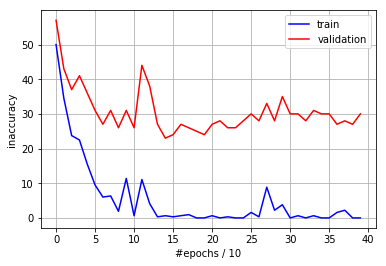

In [168]:
test_errors = compute_nb_errors(model, data_input=test_input, data_target=test_target, mini_batch_size = mini_batch_size,\
                                signal_length = SIGNAL_LENGTH, Conv2D=Conv2D)
print('test: {:0.2f}%'.format( test_errors/test_input.size(0)*100) )

plot_list(train_list_complete,test_list_complete, train_input.size(0), test_input.size(0))

In [166]:
import pickle

name = 'dil2(8)_epoch:400_drop:07_hidden:200'
pickle.dump( model, open( name + "_model.p", "wb" ) )
pickle.dump( list([train_list_complete, test_list_complete]), open( name+"_lists.p", "wb" ) )



val: 28.48%


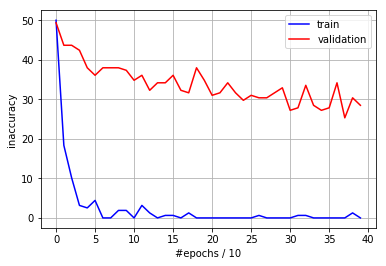

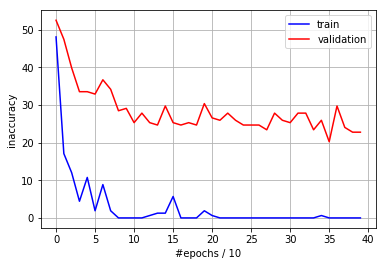

In [169]:
#print('test: {:0.2f}%'.format( test_errors/test_input.size(0)*100) )
val = np.mean(val_list_list[:][-1])
val_input_size = np.mean(val_size_list)
print('val: {:0.2f}%'.format( val/val_input_size*100) )

def plot_list(train_list,val_list, train_size, val_size):
    plt.plot(np.array(train_list)/train_size*100,'b',label='train')
    plt.plot(np.array(val_list)/ val_size*100,'r',label='validation')
    #plt.plot(np.ones(np.array(train_list).shape)*test_errors/test_input.size(0)*100,'g',label='test')
    plt.legend()
    plt.grid()
    plt.xlabel('#epochs / 10')
    plt.ylabel('inaccuracy')
    plt.show()

for i in range(len(train_list_list)):
    plot_list(train_list_list[i],val_list_list[i],train_size_list[i],val_size_list[i])